# Guitar effect

## 1. Load classes, define functions...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.constants as const
import scipy
import time as timeclass
import numpy as np
import base64
from scipy.io import wavfile
from IPython.core.display import HTML

# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    # Base on: https://nbviewer.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb
    with open(filepath,"rb") as inFile:
        baseData = base64.b64encode(inFile.read()).decode("utf-8")
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="data:audio/wav;base64,%s" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(baseData)
    display(HTML(src))


## 2. Load input file
change the "INPUT_WAVE" constant to load a different example

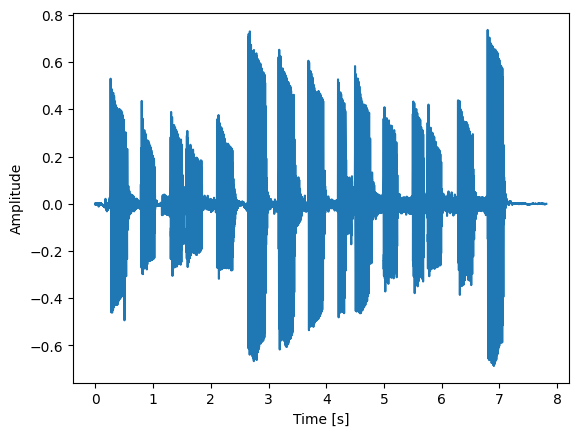

In [2]:
INPUT_WAVE = "lick2.wav"
samplerate, inputsamples = scipy.io.wavfile.read(INPUT_WAVE)
inputsamples = inputsamples / 32768.0
length = inputsamples.shape[0] / samplerate
time = np.linspace(0., length, inputsamples.shape[0])
plt.plot(time, inputsamples)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
wavPlayer(INPUT_WAVE)

## 3. Define the effect -- Change the Code here to design your own effect.

In [3]:
# Effekt definieren
# Source: https://medium.com/the-seekers-project/coding-a-basic-reverb-algorithm-part-2-an-introduction-to-audio-programming-4db79dd4e325
# Original parameters:
# Comb1: 4799 delay, gain = 0.742
# Comb2: 4999 delay, 0.733
# Comb3: 0.715, 5399
# Comb4: 0.697, 5801 delay
# All-Pass 1: 0.7, 1051
# All-Pass 2: 0.7, 337

comb1Buffer = [0] * 2317
comb2Buffer = [0] * 4913
comb3Buffer = [0] * 1373
comb4Buffer = [0] * 5132
comb1Gain = 0.742
comb2Gain = 0.733
comb3Gain = 0.715
comb4Gain = 0.697

allPass1Gain = 0.7
allPass1Buffer = [0] * 1771
allPass2Gain = 0.7
allPass2Buffer = [0] * 971

allPass1GainOneMinusSquare = 1.0 - allPass1Gain*allPass1Gain
allPass2GainOneMinusSquare = 1.0 - allPass2Gain*allPass2Gain


def effect(history):
    global allPass1Buffer, allPass2Buffer
    global comb1Buffer, comb2Buffer, comb3Buffer, comb4Buffer
    
    cur = history[0]
    c1out = comb1Buffer[0]*comb1Gain + cur
    c2out = comb2Buffer[0]*comb2Gain + cur
    c3out = comb3Buffer[0]*comb3Gain + cur
    c4out = comb4Buffer[0]*comb4Gain + cur
    comp1Buffer = comb1Buffer[1:len(comb1Buffer)]+[c1out]
    comp2Buffer = comb2Buffer[1:len(comb2Buffer)]+[c2out]
    comp3Buffer = comb3Buffer[1:len(comb3Buffer)]+[c3out]
    comp4Buffer = comb4Buffer[1:len(comb4Buffer)]+[c4out]
    
    cur = c1out+c2out+c3out+c4out
    
    a1out = allPass1Buffer[0]*allPass1Gain + cur
    allPass1Buffer = allPass1Buffer[1:len(allPass1Buffer)]+[a1out]
    cur = a1out * allPass1GainOneMinusSquare - allPass1Gain*cur
    
    a2out = allPass2Buffer[0]*allPass2Gain + cur
    allPass2Buffer = allPass2Buffer[1:len(allPass2Buffer)]+[a2out]
    cur = a2out * allPass2GainOneMinusSquare - allPass2Gain*cur
    
    return cur
    
    
    
    
    

## 4. Compute the result and play the output

Overdrive Factor:  1.0269139860978171


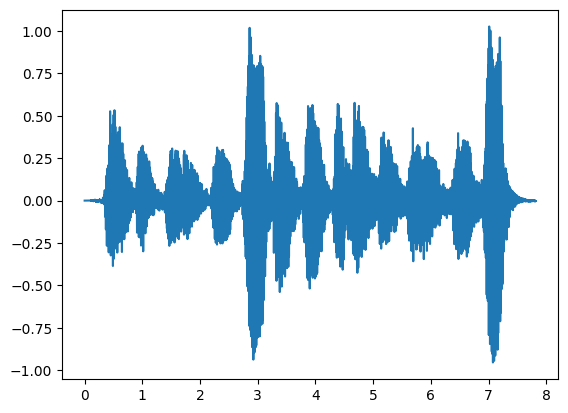

In [4]:
# Effekt ausführen und plotten
outputWave = []
for i in range(0,inputsamples.shape[0]):
    thisHistory = inputsamples[max(i-4096,0):i+1]
    np.flip(thisHistory)
    if i<4096:
        addition = np.full([4096-i-1],inputsamples[0])
        thisHistory = np.concatenate((thisHistory, addition))
    outputWave.append(effect(thisHistory))

# Fix Gain
overDrive = max(1.0,np.max(np.abs(np.array(outputWave))))
print("Overdrive Factor: ",overDrive)
    
# look at it on the first 25 ms
plt.plot(time, outputWave)

# write the file on disk, and show in in a Html 5 audio player
wavfile.write('output.wav', samplerate, (np.array(outputWave)*32768.0/overDrive).astype(np.int16))
wavPlayer("output.wav")

